## Feature Importance

### General Libraries

In [44]:
import pandas as pd
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")

### 1. Data Exploration

In [45]:
# read the data
df = pd.read_csv("D:\ProjectData\water_potability.csv")

# check data frame shape
df.shape

(3276, 10)

In [46]:
# check column names and first few rows
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [47]:
# check data types
df.dtypes

ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability           int64
dtype: object

In [48]:
# check for missing values
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

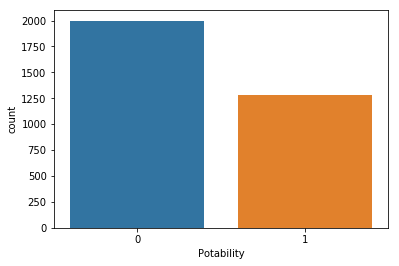

In [49]:
# check distribution of target variable
sns.countplot(data=df, x="Potability")

### 2. Data Preprocessing

In [50]:
# remove rows with na
df.dropna(inplace = True)

In [51]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# split data into input and target value
X = df.drop(["Potability"], 1)
y = df.Potability

# standardization of input data
scaler = preprocessing.StandardScaler()

X_normalized_values = scaler.fit_transform(X.values)

X_normalized = pd.DataFrame(X_normalized_values, columns=X.columns, index=X.index)


# split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.10, stratify = y, random_state=42)


### 3. Feature Importance

#### Logistic Regression - Coefficients

In [52]:
from sklearn.linear_model import LogisticRegression

# initialize logistic regression model and fit to training data
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

# obtain coefficients
coefficients = logreg.coef_.reshape(-1)

# present features and absolute values of coefficients in a dataframe
logreg_fi_df = pd.DataFrame(data = {'Feature': X.columns, 'Importance': np.abs(coefficients)}).sort_values(by = "Importance", ascending = False)
logreg_fi_df

,Feature,Importance
2,Solids,0.109760
3,Chloramines,0.046350
8,Turbidity,0.045040
5,Conductivity,0.037594
0,ph,0.030784
1,Hardness,0.016539
7,Trihalomethanes,0.016449
4,Sulfate,0.012672
6,Organic_carbon,0.003326


#### Gradient Boosted Trees 

In [53]:
from sklearn.ensemble import GradientBoostingClassifier

# initialize gradient boosted trees and fit to training data
clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)

# calculate feature importance
feature_importance = clf.feature_importances_

# present features and standardized decrease in gini impurity in a dataframe
gbt_fi_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
gbt_fi_df = gbt_fi_df.sort_values(by='Importance', ascending=False)
gbt_fi_df

,Feature,Importance
0,ph,0.290447
4,Sulfate,0.210104
2,Solids,0.133571
3,Chloramines,0.111553
1,Hardness,0.078945
7,Trihalomethanes,0.060729
6,Organic_carbon,0.047874
5,Conductivity,0.045189
8,Turbidity,0.021587


#### Neural Network - Feature permutation

In [54]:
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score

# initialise neural network and fit to training data
mlp = MLPClassifier(random_state=42, hidden_layer_sizes = (120,))
mlp.fit(X_train, y_train)

# calculate permutation importance
perm_importance = permutation_importance(mlp, X_test, y_test, n_repeats=5, random_state=42)

# present features and feature permutation importance in a dataframe
feature_importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance': perm_importance.importances_mean
})
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)
feature_importances_df

,feature,importance
4,Sulfate,0.084158
0,ph,0.075248
3,Chloramines,0.061386
1,Hardness,0.041584
2,Solids,0.024752
5,Conductivity,0.024752
6,Organic_carbon,0.019802
7,Trihalomethanes,0.018812
8,Turbidity,0.008911


#### Neural Network (SHAP)

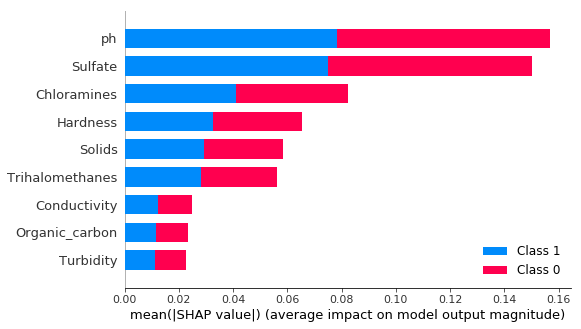

In [55]:
import shap

# compute SHAP values
explainer = shap.KernelExplainer(mlp.predict_proba, shap.sample(X_train, 100))
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")